# Project Notebook: The Linear Regression Model

## 1. Introduction

We started by building intuition for model based learning, explored how the linear regression model worked, understood how the two different approaches to model fitting worked, and some techniques for cleaning, transforming, and selecting features. In this project, you can practice what you learned by exploring ways to improve the models we built.

You'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

Let's start by setting up a pipeline of functions that will let us quickly iterate on different models.

**Tasks**

1. Import pandas, matplotlib, and numpy into the environment. Import the classes you need from scikit-learn as well.
2. Read `AmesHousing.tsv` () into a pandas data frame.
3. For the following functions, we recommend creating them in the first few cells in the notebook. This way, you can add cells to the end of the notebook to do experiments and update the functions in these cells.
* Create a function named `transform_features()` that, for now, just returns the train data frame.
* Create a function named `select_features()` that, for now, just returns the Gr Liv Area and SalePrice columns from the train data frame.
* Create a function named `train_and_test()` that, for now:

1. Selects the first 1460 rows from from data and assign to train.
2. Selects the remaining rows from data and assign to test.
3. Trains a model using all numerical columns except the SalePrice column (the target column) from the data frame returned from `select_features()`
4. Tests the model on the test set and returns the `RMSE` value.

In [80]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
#loading data 
ames_housing = pd.read_csv('https://bit.ly/3boZCX4', sep ="\t")
ames_housing.head(2)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000


In [13]:
ames_housing['Yr Sold'].unique

<bound method Series.unique of 0       2010
1       2010
2       2010
3       2010
4       2010
        ... 
2925    2006
2926    2006
2927    2006
2928    2006
2929    2006
Name: Yr Sold, Length: 2930, dtype: int64>

In [14]:
#let us create the functions first that we will use in our pipeline
#for now let us create the functions simply and we can update them in the later cells

def tranform_features(df): 
    return df


def select_features(df): 
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df.iloc[0:1460,:]
    test = df.iloc[1460:,:]
    
    selected_columns = train.select_dtypes(include = ['integer','float'])
    #let'sonly select the columns that we get from the select_features function
    columns_to_be_selected = select_features(df).columns.values.tolist()
    selected_columns = selected_columns[columns_to_be_selected]
    
    #drop the SalePrice column since it is our target variable
    selected_columns = selected_columns.drop(columns = ['SalePrice'])
    final_features = selected_columns.columns.values.tolist()
    
    lr = LinearRegression()
    lr.fit(selected_columns[final_features], train['SalePrice'])
    predictions = lr.predict(test[final_features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = mse ** (1/2)
    
    return rmse


In [15]:
#Let us quickly test our functions 
tranform_features(ames_housing).head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [16]:
select_features(ames_housing).head()

,Gr Liv Area,SalePrice
0,1656,215000
1,896,105000
2,1329,172000
3,2110,244000
4,1629,189900


In [17]:
train_and_test(ames_housing)

57088.25161263909

## 2. Feature Engineering

Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. Update `transform_features()` so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. You also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:

* remove features that we don't want to use in the model, just based on the number of missing values or data leakage.
* transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc).
* create new features by combining other features.

Next, you need to get more familiar with the remaining columns by reading the data documentation for each column, determining what transformations are necessary (if any), and more. As we mentioned earlier, succeeding in predictive modeling (and competitions like Kaggle) is highly dependent on the quality of features the model has. Libraries like scikit-learn have made it quick and easy to simply try and tweak many different models, but cleaning, selecting, and transforming features are still more of an art that requires a bit of human ingenuity.

**Tasks**

1. As we mentioned earlier, we recommend adding some cells to explore and experiment with different features (before rewriting these functions).

2. The `transform_features()` function shouldn't modify the train data frame and instead return a new one entirely. This way, we can keep using train in the experimentation cells.

3. Which columns contain less than 5% missing values?
* For numerical columns that meet this criteria, let's fill in the missing values using the most popular value for that column.

4. What new features can we create, that better capture the information in some of the features?
* An example of this would be the `years_until_remod` feature we created in the last lesson.

5. Which columns need to be dropped for other reasons?
* Which columns aren't useful for machine learning?
* Which columns leak data about the final sale?

checking missing data

In [18]:
ames_housing.isnull().sum().sort_values()

Order                0
Sale Condition       0
Heating QC           0
Central Air          0
1st Flr SF           0
                  ... 
Fireplace Qu      1422
Fence             2358
Alley             2732
Misc Feature      2824
Pool QC           2917
Length: 82, dtype: int64

In [21]:
ames_housing.shape

(2930, 82)

In [19]:
five_perc = ames_housing.shape[0]*0.05
five_perc

146.5

any column with more than 146.5 missing values should be dropped

In [22]:
housing_copy = ames_housing.copy()
housing_copy.head(2)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000


In [30]:
housing_copy.isnull().sum().sort_values(ascending = False)

Bsmt Exposure     83
BsmtFin Type 2    81
Bsmt Qual         80
Bsmt Cond         80
BsmtFin Type 1    80
                  ..
2nd Flr SF         0
1st Flr SF         0
Central Air        0
Heating QC         0
Order              0
Length: 71, dtype: int64

In [25]:
missing_data = housing_copy.isnull().sum()
columns_drop =[]

for x in missing_data.index.values.tolist(): 
    if missing_data[x] > five_perc:
        columns_drop.append(x)
    
columns_drop

['Lot Frontage',
 'Alley',
 'Fireplace Qu',
 'Garage Type',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Pool QC',
 'Fence',
 'Misc Feature']

This will be the columns to drop 

In [26]:
ames_housing.shape

(2930, 82)

In [27]:
housing_copy = housing_copy.drop(columns = columns_drop)
housing_copy.shape

(2930, 71)

picking categorical columns 

In [28]:
categorical_data = housing_copy.select_dtypes(include=['object'])
categorical_data.columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Paved Drive', 'Sale Type', 'Sale Condition'],
      dtype='object')

checking missing data for categorical data 

In [29]:
categorical_missing_data_columns = categorical_data.isnull().sum()
categorical_missing_data_columns.sort_values(ascending=False)

Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Qual         80
Bsmt Cond         80
Mas Vnr Type      23
Electrical         1
Utilities          0
Lot Config         0
Land Slope         0
Roof Matl          0
Land Contour       0
Lot Shape          0
Street             0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
House Style        0
Roof Style         0
Sale Condition     0
Exterior 1st       0
Exterior 2nd       0
Sale Type          0
Exter Qual         0
Exter Cond         0
Foundation         0
Heating            0
Heating QC         0
Central Air        0
Kitchen Qual       0
Functional         0
Paved Drive        0
MS Zoning          0
dtype: int64

drop columns with missing values, since this would affect the model quality 

In [31]:
drop_columns = categorical_missing_data_columns[categorical_missing_data_columns > 0]
drop_columns

Mas Vnr Type      23
Bsmt Qual         80
Bsmt Cond         80
Bsmt Exposure     83
BsmtFin Type 1    80
BsmtFin Type 2    81
Electrical         1
dtype: int64

In [32]:
cols = drop_columns.index.values.tolist()
cols

['Mas Vnr Type',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Electrical']

In [33]:
housing_copy = housing_copy.drop(columns = cols)
housing_copy.shape

(2930, 64)

In [34]:
housing_copy.isnull().sum()

Order             0
PID               0
MS SubClass       0
MS Zoning         0
Lot Area          0
                 ..
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
Length: 64, dtype: int64

Impute for the remaining columns with missing values below 5% with mode

In [35]:
numeric_columns = housing_copy.select_dtypes(include=['float', 'integer'])
numeric_columns.head()

,Order,PID,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,1,526301100,20,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,5,2010,215000
1,2,526350040,20,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,6,2010,105000
2,3,526351010,20,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,172000
3,4,526353030,20,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,4,2010,244000
4,5,527105010,60,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,3,2010,189900


In [36]:
columns_to_impute = numeric_columns.loc[:,(numeric_columns.isnull().sum() > 0)].columns
columns_to_impute

Index(['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars',
       'Garage Area'],
      dtype='object')

In [38]:
numerical_mode = ames_housing[columns_to_impute].mode()
numerical_mode

,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Cars,Garage Area
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [39]:
numerical_mode = numerical_mode.to_dict(orient='records')[0]
numerical_mode

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [40]:
housing_copy.fillna(numerical_mode, inplace=True)

In [41]:
housing_copy.isnull().sum().sort_values(ascending=False)

SalePrice          0
Sale Condition     0
BsmtFin SF 2       0
BsmtFin SF 1       0
Foundation         0
                  ..
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Central Air        0
Order              0
Length: 64, dtype: int64

In [42]:
housing_copy.sample(5)

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2606,2607,535401140,20,RL,8658,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1965,1965,Gable,CompShg,Wd Sdng,Wd Sdng,101.0,TA,TA,CBlock,643.0,0.0,445.0,1088.0,GasA,Ex,Y,1324,0,0,1324,0.0,0.0,2,0,3,1,TA,6,Typ,1,2.0,440.0,Y,0,138,0,0,0,0,0,12,2006,WD,Abnorml,160000
2852,2853,909250210,50,RL,6000,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,0.0,TA,Fa,BrkTil,0.0,0.0,1008.0,1008.0,GasA,Ex,Y,1008,0,514,1522,0.0,0.0,2,0,4,1,TA,7,Typ,0,0.0,0.0,P,0,0,138,0,0,0,0,6,2006,WD,Normal,102000
2105,2106,906380140,60,RL,11103,Pave,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,0.0,Gd,TA,PConc,0.0,0.0,728.0,728.0,GasA,Ex,Y,728,728,0,1456,0.0,0.0,2,1,3,1,Gd,8,Typ,1,2.0,440.0,Y,0,0,0,0,0,0,0,7,2007,New,Partial,155835
1026,1027,527357110,60,RL,9743,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,5,6,1969,1969,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,280.0,0.0,440.0,720.0,GasA,Gd,Y,720,588,0,1308,0.0,0.0,1,1,3,1,TA,7,Typ,0,2.0,484.0,Y,0,0,0,0,0,0,0,6,2008,WD,Normal,146900
485,486,528280230,60,RL,12224,Pave,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,40.0,Gd,TA,PConc,695.0,0.0,297.0,992.0,GasA,Ex,Y,1022,1032,0,2054,1.0,0.0,2,1,3,1,Gd,7,Typ,1,2.0,390.0,Y,24,48,0,0,0,0,0,7,2009,WD,Normal,244000


In [43]:
housing_copy['years_until_remod'] = housing_copy['Year Remod/Add'] - housing_copy['Year Built']
housing_copy['years_until_remod'].sort_values(ascending = True)


850      -1
0         0
1685      0
1683      0
1682      0
       ... 
1942    116
215     121
1306    122
716     123
806     127
Name: years_until_remod, Length: 2930, dtype: int64

checking the -1 value from difference between year remodeled versus year built and dropping row with index 850

In [44]:
housing_copy.drop(index = 850, inplace=True)

In [45]:
housing_copy.shape

(2929, 65)

drop the year remodeled and year built 

In [46]:
housing_copy.drop(columns=['Year Remod/Add','Year Built'], inplace=True)

In [47]:
housing_copy.shape

(2929, 63)

In [48]:
housing_copy.head(2)

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_until_remod
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,5,2010,WD,Normal,215000,0
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,105000,0


check columns to be dropped that are not necessary to the model prediction 

The house will already be sold at this point

 Sale Condition: Condition of sale,
 Sale Type: Type of sale,
 Mo Sold: Month Sold (MM) and 
 Yr Sold: Year Sold (YYYY)

count of rows: order 
house identification: PID

In [49]:
housing_copy.drop(columns = ['Order','PID','Mo Sold','Yr Sold','Sale Type','Sale Condition'], inplace=True)

In [50]:
housing_copy.head(2)

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,years_until_remod
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,215000,0
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,105000,0


In [51]:
housing_copy.shape

(2929, 57)

## 3. Feature Selection

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.

**Tasks**

1. Generate a correlation heatmap matrix of the numerical features in the training data set.
* Which features correlate strongly with our target column, `SalePrice`?
* Calculate the correlation coefficients for the columns that seem to correlate well with `SalePrice`. Because we have a pipeline in place, it's easy to try different features and see which features result in a better cross validation score.

2. Which columns in the data frame should be converted to the categorical data type? All of the columns that can be categorized as nominal variables are candidates for being converted to categorical. Here are some other things you should think about:
* If a categorical column has hundreds of unique values (or categories), should you keep it? When you dummy code this column, hundreds of columns will need to be added back to the data frame.
* Which categorical columns have a few unique values but more than 95% of the values in the column belong to a specific category? This would be similar to a low variance numerical feature (no variability in the data for the model to capture).

3. Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?

4. What are some ways we can explore which categorical columns "correlate" well with `SalePrice`?

5. Update the logic for the `select_features()` function. This function should take in the new, modified train and test data frames that were returned from `transform_features()`.

selecting numeric columns features

check correlation between features 
and correlation between features and target

In [52]:
numerical_cols = housing_copy.select_dtypes(include = ['integer', 'float']) 

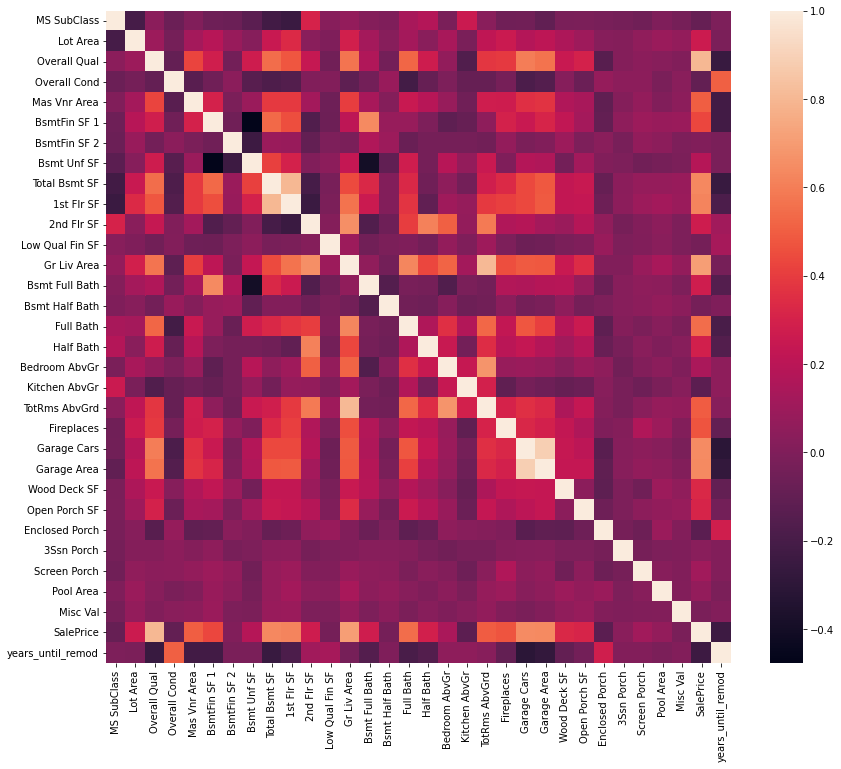

In [54]:
corrmat = numerical_cols.corr()
corrmat

#Now, the data is in the right shape to be passed into seaborn.heatmap().
plt.figure(figsize = (14,12))
sns.heatmap(corrmat)

the following features have a strong between each other:-
1. garage cars and garage area 
2. totrms abvgrd and Gr liv area

drop 2 columns to avoid duplication

In [55]:
housing_copy.drop(columns = ['Garage Cars', 'TotRms AbvGrd'], inplace=True)

In [56]:
housing_copy.shape

(2929, 55)

correlation between features and target

In [57]:
new_numerical_cols = housing_copy.select_dtypes(include = ['float', 'integer'])
new_numerical_cols = new_numerical_cols.corr()
new_numerical_cols['SalePrice'].abs().sort_values(ascending=False)

SalePrice            1.000000
Overall Qual         0.799268
Gr Liv Area          0.706801
Garage Area          0.640126
Total Bsmt SF        0.632536
1st Flr SF           0.621671
Full Bath            0.545594
Mas Vnr Area         0.502223
Fireplaces           0.474722
BsmtFin SF 1         0.433221
Wood Deck SF         0.327119
Open Porch SF        0.312966
Half Bath            0.285159
Bsmt Full Bath       0.275779
2nd Flr SF           0.269479
Lot Area             0.266546
years_until_remod    0.240129
Bsmt Unf SF          0.183418
Bedroom AbvGr        0.143899
Enclosed Porch       0.128758
Kitchen AbvGr        0.119797
Screen Porch         0.112181
Overall Cond         0.101655
MS SubClass          0.085021
Pool Area            0.068410
Low Qual Fin SF      0.037651
Bsmt Half Bath       0.035794
3Ssn Porch           0.032235
Misc Val             0.015683
BsmtFin SF 2         0.006046
Name: SalePrice, dtype: float64

overall_qual, gr_liv_area and sales_price have a strong positive correlation

Picking columns that have a correlation greater than 0.3

In [58]:
corr_below = new_numerical_cols['SalePrice'].abs().sort_values()
corr_below = corr_below[corr_below < 0.3].index.values.tolist()
corr_below

['BsmtFin SF 2',
 'Misc Val',
 '3Ssn Porch',
 'Bsmt Half Bath',
 'Low Qual Fin SF',
 'Pool Area',
 'MS SubClass',
 'Overall Cond',
 'Screen Porch',
 'Kitchen AbvGr',
 'Enclosed Porch',
 'Bedroom AbvGr',
 'Bsmt Unf SF',
 'years_until_remod',
 'Lot Area',
 '2nd Flr SF',
 'Bsmt Full Bath',
 'Half Bath']

drop columns with correlation below 0.3

In [59]:
housing_copy.drop(columns = corr_below, inplace = True)

selecting categorical features

In [60]:
housing_copy.shape

(2929, 37)

In [61]:
categorical_cols = housing_copy.select_dtypes(include=['object'])

In [62]:
categorical_cols.nunique().sort_values(ascending = True)

Street           2
Central Air      2
Paved Drive      3
Utilities        3
Land Slope       3
Lot Shape        4
Land Contour     4
Exter Qual       4
Lot Config       5
Kitchen Qual     5
Heating QC       5
Bldg Type        5
Exter Cond       5
Heating          6
Foundation       6
Roof Style       6
MS Zoning        7
Roof Matl        8
Functional       8
House Style      8
Condition 2      8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

drop columns with many unique values 

In [63]:
housing_copy.drop(columns = ['Exterior 1st', 'Exterior 2nd','Neighborhood'], inplace=True)

In [64]:
housing_copy.shape

(2929, 34)

In [65]:
categorical_cols.drop(columns = ['Exterior 1st', 'Exterior 2nd','Neighborhood'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
categorical_cols.shape

(2929, 22)

encode categorical data 

In [67]:
categorical_cols= categorical_cols.astype('category')
categorical_cols.dtypes

MS Zoning       category
Street          category
Lot Shape       category
Land Contour    category
Utilities       category
Lot Config      category
Land Slope      category
Condition 1     category
Condition 2     category
Bldg Type       category
House Style     category
Roof Style      category
Roof Matl       category
Exter Qual      category
Exter Cond      category
Foundation      category
Heating         category
Heating QC      category
Central Air     category
Kitchen Qual    category
Functional      category
Paved Drive     category
dtype: object

In [68]:
for col in categorical_cols.columns: 
  housing_copy[col] = housing_copy[col].astype('category')

housing_copy.dtypes

MS Zoning        category
Street           category
Lot Shape        category
Land Contour     category
Utilities        category
Lot Config       category
Land Slope       category
Condition 1      category
Condition 2      category
Bldg Type        category
House Style      category
Overall Qual        int64
Roof Style       category
Roof Matl        category
Mas Vnr Area      float64
Exter Qual       category
Exter Cond       category
Foundation       category
BsmtFin SF 1      float64
Total Bsmt SF     float64
Heating          category
Heating QC       category
Central Air      category
1st Flr SF          int64
Gr Liv Area         int64
Full Bath           int64
Kitchen Qual     category
Functional       category
Fireplaces          int64
Garage Area       float64
Paved Drive      category
Wood Deck SF        int64
Open Porch SF       int64
SalePrice           int64
dtype: object

use dummy coding to assign 0 or 1 to categorical features

In [69]:
dummy_values = pd.get_dummies(categorical_cols)
dummy_values.head(2)

,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,...,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_N,Central Air_Y,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


Convert all the remaining categorical columns in housing copy to corresponding dummies and delete original columns

In [70]:
for col in categorical_cols.columns:
  dummies = pd.get_dummies(housing_copy[col])
  housing_copy = pd.concat([housing_copy, dummies], axis = 1)
  del housing_copy[col]

In [71]:
housing_copy.head(2)

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,Fireplaces,Garage Area,Wood Deck SF,Open Porch SF,SalePrice,A (agr),C (all),FV,I (all),RH,RL,RM,Grvl,Pave,IR1,IR2,IR3,Reg,Bnk,HLS,Low,Lvl,AllPub,NoSeWa,NoSewr,Corner,CulDSac,FR2,FR3,Inside,Gtl,Mod,Sev,...,Ex,Fa,Gd,Po,TA,BrkTil,CBlock,PConc,Slab,Stone,Wood,Floor,GasA,GasW,Grav,OthW,Wall,Ex,Fa,Gd,Po,TA,N,Y,Ex,Fa,Gd,Po,TA,Maj1,Maj2,Min1,Min2,Mod,Sal,Sev,Typ,N,P,Y
0,6,112.0,639.0,1080.0,1656,1656,1,2,528.0,210,62,215000,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,0,730.0,140,0,105000,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


Update functions created earlier ; transform_features and select_features

In [72]:
def tranform_features(df):
    
    df_copy = df.copy()
    cutoff = df_copy.shape[0] * 0.05

    #drop numerical columns with missing data
    numerical_cols = df_copy.select_dtypes(include = ['integer','float'])
    missing_numerical = numerical_cols.isnull().sum()
    drop_numerical_columns = []
    for x in missing_numerical.index.values.tolist():
        if missing_numerical[x] > cutoff:
            drop_numerical_columns.append(x)
    df_copy.drop(columns = drop_numerical_columns, inplace = True)

    #drop categorical data with missing values
    categorical_data = df_copy.select_dtypes(include = ['object'])
    categorical_missing_data = categorical_data.isnull().sum().sort_values(ascending = False)
    drop_columns = categorical_missing_data[categorical_missing_data > 0]
    cat_cols = drop_columns.index.values.tolist()
    df_copy.drop(columns = cat_cols , inplace=True)
    
    #impute the remaining missing values with summary statistic
    numerical = df_copy.select_dtypes(include = ['integer','float'])
    numerical_cols_impute = numerical.loc[:,(numerical.isnull().sum() > 0)].columns
    numerical_mode = df_copy[numerical_cols_impute].mode().to_dict(orient = 'records')[0]
    df_copy.fillna(numerical_mode, inplace = True)

    #feature engineering - adding new features
    df_copy['year_until_remod'] = df_copy['Year Remod/Add'] - df_copy['Year Built']
    df_copy.drop(index = 850, inplace = True)
    df_copy.drop(columns = ['Year Remod/Add','Year Built'], inplace = True)
    df_copy.drop(columns = ['Order','PID','Mo Sold','Yr Sold','Sale Type','Sale Condition'], inplace = True)
    
    
    return df_copy

In [74]:
def select_features(df_copy, correlation_cutoff, uniqueness_cutoff):
    #two factors to consider - Correlation with target column and correlation with other features
    df_copy2 = df_copy.copy()
    df_copy2 = df_copy2.drop(columns = ['Garage Cars','TotRms AbvGrd'])

    #select numerical cols and base on correlation values decide which columns to keep
    numerical_cols = df_copy2.select_dtypes(include = ['integer','float'])
    numerical_correlation = numerical_cols.corr()
    target_correl = numerical_correlation['SalePrice'].abs().sort_values()
    corr_below_cutoff = target_correl[target_correl < correlation_cutoff].index.values.tolist()
    df_copy2 = df_copy2.drop(columns = corr_below_cutoff)

    #select categorical columns and convert them to numerical variables
    #dropping columns with alot of unique values
    categorical_only = df_copy2.select_dtypes(include = ['object'])
    unique_heavy_columns = [col for col in categorical_only.columns if len(categorical_only[col].value_counts()) > uniqueness_cutoff]
    df_copy2 = df_copy2.drop(columns = unique_heavy_columns)

    #converting the remaining categorical columns to dummies
    categorical_columns_only = df_copy2.select_dtypes(include = ['object'])
    for columns in categorical_columns_only.columns: 
        df_copy2[columns] = df_copy2[columns].astype('category')

    #converting to dummies
    for columns in categorical_columns_only.columns:
        dummies = pd.get_dummies(df_copy2[columns])
        df_copy2 = pd.concat([df_copy2,dummies], axis = 1)
        del df_copy2[columns]
    
    return df_copy2
    

## 4. Train and Test

Now for the final part of the pipeline, training and testing. When iterating on different features, using simple validation is a good idea. Let's add a parameter named `k` that controls the type of cross validation that occurs.

**Tasks**

1. The optional `k` parameter should accept integer values, with a default value of `0`.

2. When `k` equals `0`, perform holdout validation (what we already implemented):

* Select the first `1460` rows and assign to `train`.
* Select the remaining rows and assign to test.
* Train on `train` and `test` on test.
* Compute the `RMSE` and return.

3. When k equals 1, perform simple cross validation:

* Shuffle the ordering of the rows in the data frame.
* Select the first 1460 rows and assign to `fold_one`.
* Select the remaining rows and assign to `fold_two`.
* Train on `fold_one` and test on `fold_two`.
* Train on `fold_two` and test on `fold_one`.
* Compute the average RMSE and return.

4. When `k` is greater than `0`, implement k-fold cross validation using `k` folds:

* Perform `k-fold` cross validation using k folds.
* Calculate the average `RMSE` value and return this value.

In [75]:
def train_and_test(df_copy2,k):
    df_copy3 = df_copy2.copy()
    numeric = df_copy3.select_dtypes(include = ['integer','float'])
    columns_numeric = numeric.drop(columns = ['SalePrice'])
    cols = columns_numeric.columns.values.tolist()
    lr = LinearRegression()

    if k == 0: 
        train = df_copy3[0:1460]
        test = df_copy3[1460:]
        lr.fit(train[cols], train['SalePrice'])
        predictions = lr.predict(test[cols])
        mse = mean_squared_error(test['SalePrice'],predictions)
        rmse = mse ** (1/2)
        
        return rmse

    if k == 1: 
        shuffle_df = df_copy3.sample(frac = 1)
        shuffle_df = shuffle_df.reset_index()
        shuffle_df = shuffle_df.drop(columns = ['index'])
        
        #When we call the reset_index function, a new index column is added. The rows are still sorted.
        #Hence we decided to drop the index column
        
        fold_one = shuffle_df[0:1460]
        fold_two = shuffle_df[1460:]
        
        lr.fit(fold_one[cols],fold_one['SalePrice'])
        predictions_one = lr.predict(fold_two[cols])
        mse_one = mean_squared_error(fold_two['SalePrice'], predictions_one)
        rmse_one = mse_one ** (1/2)

        lr.fit(fold_two[cols], fold_two['SalePrice'])
        predictions_two = lr.predict(fold_one[cols])
        mse_two = mean_squared_error(fold_one['SalePrice'], predictions_two)
        rmse_two = mse_two ** (1/2)
        
        avg_rmse = np.mean([rmse_one,rmse_two])
        
        return avg_rmse

    else:
        #if k is more than one, then we perform KFold cross validation
        kf = KFold(n_splits = k, shuffle = True)
        mses = cross_val_score(lr,df_copy3[cols], df_copy3['SalePrice'], scoring = 'neg_mean_squared_error', cv = kf)
        rmses = np.sqrt(np.absolute(mses))
        avg_rmse_k_fold = np.mean(rmses)
        
        return avg_rmse_k_fold

In [77]:
final_housing = pd.read_csv('https://bit.ly/3boZCX4', sep ="\t")
transformed_data = tranform_features(final_housing)

In [78]:
selected_features_data = select_features(transformed_data, 0.3, 10)

In [79]:
for x in range(0,10,1): 
    print(train_and_test(selected_features_data,k = x))

38019.23639927235
32566.861000460212
32612.473058739302
31519.02199445498
32007.97754235444
31921.47031027558
31718.82967840225
31470.59257469362
31043.915509593804
31294.098799380856


## 5. Next Steps

That's it for the guided steps. Here's some potenial next steps that you can take:

1. Continue iteration on feature engineering:
* Research some other approaches to feature engineering online around housing data.
* Visit the Kaggle kernels [page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels) page for this dataset to see approaches others took.

2. Improve your feature selection:
* Research ways of doing feature selection better with categorical columns (something we didn't cover in this particular course).